<a href="https://colab.research.google.com/github/gkdivya/CNN/blob/master/omdena_weedbot_weeddetectormodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weed Detector Model 

### Running GPU?

## Load Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, MaxPooling2D, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
import keras
from keras.metrics import MeanIoU
from keras import backend as K
from keras.layers import BatchNormalization


import numpy as np
import cv2
import json
import random



from sklearn.preprocessing import minmax_scale as normalize
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

### Upgrade Keras Version if required

In [ ]:
#! pip3 install --upgrade tensorflow
#! pip3 install keras --upgrade
##! pip install tensorflow-gpu

In [ ]:
img_width = 320
img_height = 320
input_channel = 11
output_channel = 3
episilon = 0.002

## ActiveLoop Data Loader

In [ ]:
## Install Hub to access datatset
! pip3 install hub

     |████████████████████████████████| 112kB 15.7MB/s 
     |████████████████████████████████| 337kB 27.7MB/s 
     |████████████████████████████████| 133kB 44.2MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 133kB 52.0MB/s 
     |████████████████████████████████| 296kB 59.0MB/s 
     |████████████████████████████████| 2.2MB 53.6MB/s 
     |████████████████████████████████| 102kB 14.7MB/s 
     |████████████████████████████████| 1.8MB 55.4MB/s 
     |████████████████████████████████| 2.6MB 58.6MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 133kB 64.6MB/s 
     |████████████████████████████████| 5.8MB 39.3MB/s 
     |████████████████████████████████| 71kB 12.4MB/s 
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 7.2MB 48.6MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 


In [ ]:
# Load Dataset
import hub
tag = "sijpapi/crop_carrot_mini_50"
ds = hub.Dataset(tag)

In [ ]:
print("Number of images total --- ", len(ds))

Number of images total ---  19375


In [ ]:
## Train/Test Split
split_prop = 0.9
split = int(split_prop * len(ds))
ds_train = ds[:split]
ds_val = ds[split:]

## Data Loader

In [ ]:
## Data Generator
### Train & Validation
def train_generator(batch_size):
  
    while True:
        for start in range(0, len(ds_train), batch_size):
            end = min(start + batch_size, len(ds_train))
            
            x_batch = ds_train["image"][start:end].numpy()
            y_batch = ds_train["label"][start:end].numpy()
            

            yield ((x_batch).astype(np.float32) / 255.0, y_batch / 255.0)


def valid_generator(batch_size):
  
    while True:
        for start in range(0, len(ds_val), batch_size):
            end = min(start + batch_size, len(ds_val))
            
            x_batch = ds_val["image"][start:end].numpy()
            y_batch = ds_val["label"][start:end].numpy()

            yield ((x_batch).astype(np.float32) / 255.0, y_batch / 255.0)
            #

## Loss Functions

### Experiment with the two below or try others

In [ ]:
# Focal Tversky_loss
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))


# Dice Loss
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Semantic Segmentation 

### Modified uNet
### Currently trained from scratch. 
### Modify architecture, try different backbone or implement transfer learning

In [ ]:
## Modified uNet
def semantic_segmentation(pretrained_weights=None, input_size=(img_height, img_width, input_channel)):
  inputs = Input(input_size)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


  conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  drop5 = Dropout(0.5)(conv5)



  up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

  conv10 = Conv2D(3, 1, activation = 'softmax')(conv9)

  model = Model(inputs, conv10)

  model.compile(optimizer=Adam(lr=3e-5), loss=focal_tversky_loss, metrics=[MeanIoU(num_classes=3)])

  if pretrained_weights:
    model.load(pretrained_weights)

  return(model)

  

In [ ]:
## Checkpoint Weights
filepath="checkpoint/wdmh4layerunet-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto', save_freq=10)

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [ ]:
segment = semantic_segmentation(input_size=(img_height, img_width, input_channel))

## Train Function
def train(epochs, batch_size):
  segment.fit(train_generator(batch_size), 
                      epochs= epochs,
                      steps_per_epoch= len(ds_train) // batch_size,
                      validation_data= valid_generator(batch_size),
                      validation_steps = len(ds_val) // batch_size, 
                      callbacks=[es, checkpoint])

In [ ]:
# View Architecture summary
segment.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 11 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 1600        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 160, 160, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 9280        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
## Start Training args -- num_epochs & batch size
## 64 appears to be a good number for Colab
train(10, 64)

Epoch 1/10
 10/272 [>.............................] - ETA: 3:46 - loss: 0.6009 - mean_io_u: 0.3367
Epoch 00001: loss improved from inf to 0.59502, saving model to checkpoint/wdmh4layerunet-01-0.60.hdf5
 20/272 [=>............................] - ETA: 3:46 - loss: 0.5941 - mean_io_u: 0.3367
Epoch 00001: loss improved from 0.59502 to 0.58101, saving model to checkpoint/wdmh4layerunet-01-0.58.hdf5
 30/272 [==>...........................] - ETA: 3:35 - loss: 0.5872 - mean_io_u: 0.3366
Epoch 00001: loss improved from 0.58101 to 0.56677, saving model to checkpoint/wdmh4layerunet-01-0.57.hdf5
 40/272 [===>..........................] - ETA: 3:24 - loss: 0.5799 - mean_io_u: 0.3366
Epoch 00001: loss improved from 0.56677 to 0.55119, saving model to checkpoint/wdmh4layerunet-01-0.55.hdf5
 50/272 [====>.........................] - ETA: 3:14 - loss: 0.5724 - mean_io_u: 0.3366
Epoch 00001: loss improved from 0.55119 to 0.53483, saving model to checkpoint/wdmh4layerunet-01-0.53.hdf5
 60/272 [=====>...

## Inference

## Loading saved model

In [ ]:
# Load Checkpoint Model
#segment = keras.models.load_model("/content/checkpoint/wdmh4layerunet-10-0.61.hdf5", compile=False)

In [ ]:
# Get Images from Validation Data
test_data = next(valid_generator(5))

In [ ]:
# Get images & masks
test_img = test_data[0]
test_mask = test_data[1]

### Plot Original, Ground Truth and Predictions

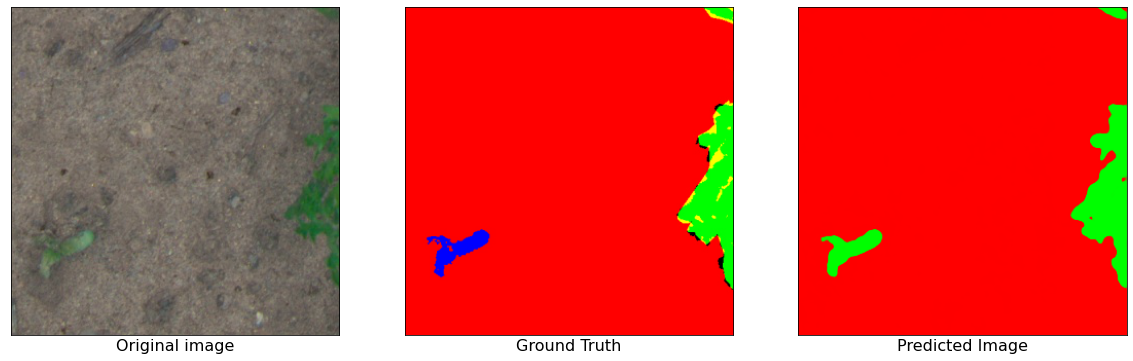

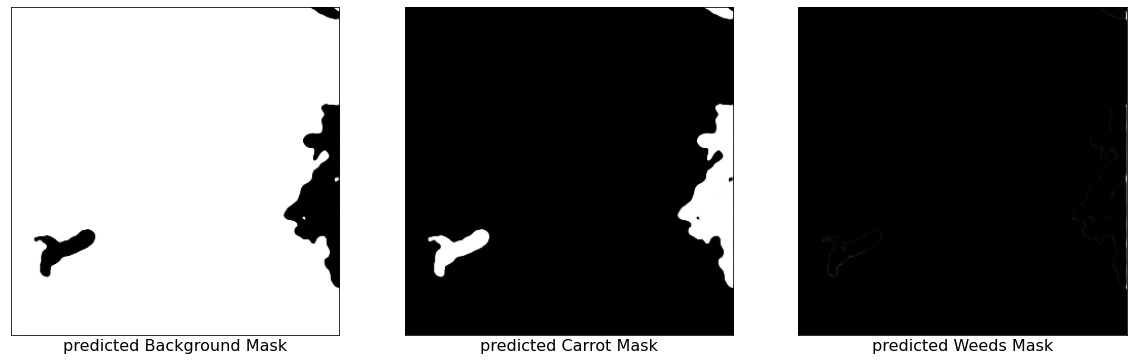

In [ ]:
# If you load with batchsize 40 in valid generator, the max index will be 39
# Indices we should try 6, 7, 10, 20, 27, 31 so that we can compare those indices with our models
img_index = 33

# Run inference on Validation data
test_i = segment(test_img[img_index , :, :, :].reshape(1, img_height, img_width, input_channel)).numpy()
test_i = test_i.reshape((img_height, img_width, output_channel))

img_list1 = [test_img[img_index , :, :, :3], test_mask[img_index , :, :, :3], test_i ]
label_list1 = ['Original image', 'Ground Truth', 'Predicted Image']
plt.figure(figsize=(20, 20))
ctr = 0

for i in img_list1:
  ctr +=1
  plt.subplot(1,3,ctr)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label_list1[ctr-1], fontsize=16)
  plt.imshow(i)

img_list2 = [test_i[:, :, 0], test_i[:, :, 1], test_i[:, :, 2]]
label_list2 = ['predicted Background Mask', 'predicted Carrot Mask', 'predicted Weeds Mask']
plt.figure(figsize=(20, 20))
ctr = 0

for i in img_list2:
  ctr +=1
  plt.subplot(1,3,ctr)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label_list2[ctr-1], fontsize=16)
  plt.imshow(i, cmap="gray")
